Quick Summary: 
1. MSE for patient_pay is 715 with trained model (2000 iterations, depth=6, learning rate =0.1 with all features:'pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group')

2. Prediction for rejection doesn't work well even with increased number iterations. But given the model trained by nonrejected data. Rejected cases would have a higher hypothetical paytient pay given observable features. 

3. The most important feature for rejection/approval is drug type(branded/generic) and then name. The most important feature for patient pay is drug name, then insurance group. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier,CatBoostRegressor, Pool

In [2]:
# Read data

df = pd.read_csv('pharmacy_tx.csv')
drugsplit=df['drug'].str.split(" ",n=1,expand=True)
df['drug_type']=drugsplit[0]
df['drug_name']=drugsplit[1]
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_type,drug_name
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39,branded,tanoclolol
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02,branded,oxasoted
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39,branded,cupitelol
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84,generic,oxasoted
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00,branded,mamate
...,...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,Pharmacy #42,U27.71,branded colifunene,322463,NaN,HO8HUGL,True,0.00,branded,colifunene
13910240,2022-12-30,Pharmacy #45,N59.44,generic tafistitrisin,664344,NaN,TFZOR5R49,False,6.28,generic,tafistitrisin
13910241,2022-12-30,Pharmacy #54,W50.87,generic tanoclolol,691847,N098KI,6SP1DG,False,6.94,generic,tanoclolol
13910242,2022-12-30,Pharmacy #0,I68.27,branded prazinib,96934,S76J7V6,NaN,False,13.93,branded,prazinib


In [3]:
# Fill NAN by "missing" string
df[['pcn', 'group']] = df[['pcn','group']].fillna('Missing')
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_type,drug_name
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,Missing,False,13.39,branded,tanoclolol
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,Missing,52H8KH0F83K,False,7.02,branded,oxasoted
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,Missing,False,13.39,branded,cupitelol
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84,generic,oxasoted
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,Missing,ZX2QUWR,False,47.00,branded,mamate
...,...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,Pharmacy #42,U27.71,branded colifunene,322463,Missing,HO8HUGL,True,0.00,branded,colifunene
13910240,2022-12-30,Pharmacy #45,N59.44,generic tafistitrisin,664344,Missing,TFZOR5R49,False,6.28,generic,tafistitrisin
13910241,2022-12-30,Pharmacy #54,W50.87,generic tanoclolol,691847,N098KI,6SP1DG,False,6.94,generic,tanoclolol
13910242,2022-12-30,Pharmacy #0,I68.27,branded prazinib,96934,S76J7V6,Missing,False,13.93,branded,prazinib


In [4]:
Y=df.patient_pay
Y_r=1*(df.rejected==1)
#X=df[['diagnosis','drug_type','drug_name','bin','pcn','group']]
X=df[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]

In [5]:
sum(Y_r)

1086860

In [5]:
#subsample data
X_train, X_test, y_r_train, y_r_test = train_test_split(X.copy(),Y_r.copy(),
                                                       shuffle=True,
                                                       random_state=222,
                                                       stratify=Y_r,
                                                       test_size=.2)

In [49]:
sum(y_r_train)

869488

In [6]:
cat_features = np.where(X.dtypes != float)[0]
train_data=Pool(data=X_train,label=y_r_train,cat_features=cat_features)

In [7]:
model_r= CatBoostClassifier(iterations=2000,depth=6,learning_rate=0.4)
#max_ctr_complexity=1
#learning_rate=0.1,depth=8,task_type="GPU",devices='0:1'
model_r.fit(train_data)
#,plot='true'

0:	learn: 0.3398070	total: 3.55s	remaining: 1h 58m 20s
1:	learn: 0.2703305	total: 6.78s	remaining: 1h 52m 50s
2:	learn: 0.2108710	total: 11.8s	remaining: 2h 11m 23s
3:	learn: 0.3990558	total: 18.4s	remaining: 2h 33m 21s
4:	learn: 0.3899607	total: 22.4s	remaining: 2h 29m 7s
5:	learn: 0.3863432	total: 28.5s	remaining: 2h 37m 44s
6:	learn: 0.3859285	total: 33.8s	remaining: 2h 40m 36s
7:	learn: 0.3806222	total: 38.2s	remaining: 2h 38m 38s
8:	learn: 0.3803578	total: 42.1s	remaining: 2h 35m 6s
9:	learn: 0.3781567	total: 46.4s	remaining: 2h 33m 53s
10:	learn: 0.3778625	total: 50.3s	remaining: 2h 31m 28s
11:	learn: 0.3777058	total: 54.3s	remaining: 2h 29m 51s
12:	learn: 0.3756106	total: 1m	remaining: 2h 33m 9s
13:	learn: 0.3750375	total: 1m 4s	remaining: 2h 33m 5s
14:	learn: 0.3744602	total: 1m 10s	remaining: 2h 35m 45s
15:	learn: 0.3744481	total: 1m 16s	remaining: 2h 38m 24s
16:	learn: 0.3742364	total: 1m 22s	remaining: 2h 39m 29s
17:	learn: 0.3737663	total: 1m 27s	remaining: 2h 39m 43s
18:	l

145:	learn: 0.2623328	total: 10m 51s	remaining: 2h 17m 52s
146:	learn: 0.2623319	total: 10m 54s	remaining: 2h 17m 35s
147:	learn: 0.2623311	total: 10m 59s	remaining: 2h 17m 27s
148:	learn: 0.2623295	total: 11m 2s	remaining: 2h 17m 13s
149:	learn: 0.2613853	total: 11m 6s	remaining: 2h 17m 2s
150:	learn: 0.2613851	total: 11m 10s	remaining: 2h 16m 45s
151:	learn: 0.2613833	total: 11m 14s	remaining: 2h 16m 34s
152:	learn: 0.2576943	total: 11m 21s	remaining: 2h 17m 1s
153:	learn: 0.2576919	total: 11m 28s	remaining: 2h 17m 30s
154:	learn: 0.2575718	total: 11m 33s	remaining: 2h 17m 29s
155:	learn: 0.2554473	total: 11m 38s	remaining: 2h 17m 40s
156:	learn: 0.2551974	total: 11m 43s	remaining: 2h 17m 40s
157:	learn: 0.2551966	total: 11m 48s	remaining: 2h 17m 38s
158:	learn: 0.2551962	total: 11m 53s	remaining: 2h 17m 37s
159:	learn: 0.2551957	total: 11m 57s	remaining: 2h 17m 32s
160:	learn: 0.2551949	total: 12m 2s	remaining: 2h 17m 27s
161:	learn: 0.2541813	total: 12m 7s	remaining: 2h 17m 30s
162

285:	learn: 0.2439670	total: 21m 24s	remaining: 2h 8m 15s
286:	learn: 0.2439642	total: 21m 29s	remaining: 2h 8m 13s
287:	learn: 0.2439638	total: 21m 34s	remaining: 2h 8m 16s
288:	learn: 0.2439631	total: 21m 37s	remaining: 2h 8m 1s
289:	learn: 0.2439628	total: 21m 41s	remaining: 2h 7m 55s
290:	learn: 0.2439621	total: 21m 45s	remaining: 2h 7m 46s
291:	learn: 0.2439618	total: 21m 49s	remaining: 2h 7m 38s
292:	learn: 0.2439611	total: 21m 52s	remaining: 2h 7m 27s
293:	learn: 0.2439605	total: 21m 56s	remaining: 2h 7m 16s
294:	learn: 0.2439597	total: 21m 59s	remaining: 2h 7m 7s
295:	learn: 0.2437014	total: 22m 3s	remaining: 2h 6m 58s
296:	learn: 0.2437007	total: 22m 7s	remaining: 2h 6m 51s
297:	learn: 0.2436155	total: 22m 11s	remaining: 2h 6m 42s
298:	learn: 0.2436152	total: 22m 15s	remaining: 2h 6m 37s
299:	learn: 0.2436150	total: 22m 18s	remaining: 2h 6m 25s
300:	learn: 0.2436148	total: 22m 22s	remaining: 2h 6m 19s
301:	learn: 0.2436143	total: 22m 26s	remaining: 2h 6m 13s
302:	learn: 0.2436

427:	learn: 0.2419902	total: 30m 43s	remaining: 1h 52m 51s
428:	learn: 0.2419886	total: 30m 47s	remaining: 1h 52m 46s
429:	learn: 0.2419879	total: 30m 52s	remaining: 1h 52m 43s
430:	learn: 0.2419875	total: 30m 56s	remaining: 1h 52m 36s
431:	learn: 0.2419871	total: 31m	remaining: 1h 52m 32s
432:	learn: 0.2419859	total: 31m 4s	remaining: 1h 52m 28s
433:	learn: 0.2419846	total: 31m 9s	remaining: 1h 52m 25s
434:	learn: 0.2419835	total: 31m 14s	remaining: 1h 52m 22s
435:	learn: 0.2419827	total: 31m 18s	remaining: 1h 52m 19s
436:	learn: 0.2419821	total: 31m 23s	remaining: 1h 52m 15s
437:	learn: 0.2419812	total: 31m 29s	remaining: 1h 52m 17s
438:	learn: 0.2419806	total: 31m 33s	remaining: 1h 52m 12s
439:	learn: 0.2419800	total: 31m 37s	remaining: 1h 52m 9s
440:	learn: 0.2419795	total: 31m 42s	remaining: 1h 52m 4s
441:	learn: 0.2419786	total: 31m 46s	remaining: 1h 52m
442:	learn: 0.2419781	total: 31m 50s	remaining: 1h 51m 55s
443:	learn: 0.2419760	total: 31m 55s	remaining: 1h 51m 51s
444:	lear

568:	learn: 0.2411281	total: 39m 45s	remaining: 1h 39m 59s
569:	learn: 0.2411276	total: 39m 48s	remaining: 1h 39m 53s
570:	learn: 0.2411266	total: 39m 52s	remaining: 1h 39m 47s
571:	learn: 0.2411258	total: 39m 56s	remaining: 1h 39m 42s
572:	learn: 0.2411255	total: 40m	remaining: 1h 39m 38s
573:	learn: 0.2411250	total: 40m 4s	remaining: 1h 39m 33s
574:	learn: 0.2411236	total: 40m 9s	remaining: 1h 39m 30s
575:	learn: 0.2411230	total: 40m 13s	remaining: 1h 39m 26s
576:	learn: 0.2411228	total: 40m 17s	remaining: 1h 39m 21s
577:	learn: 0.2411228	total: 40m 21s	remaining: 1h 39m 16s
578:	learn: 0.2411212	total: 40m 25s	remaining: 1h 39m 13s
579:	learn: 0.2411208	total: 40m 30s	remaining: 1h 39m 9s
580:	learn: 0.2411197	total: 40m 34s	remaining: 1h 39m 5s
581:	learn: 0.2411188	total: 40m 38s	remaining: 1h 39m 1s
582:	learn: 0.2411179	total: 40m 42s	remaining: 1h 38m 57s
583:	learn: 0.2411171	total: 40m 46s	remaining: 1h 38m 52s
584:	learn: 0.2411159	total: 40m 50s	remaining: 1h 38m 48s
585:	l

708:	learn: 0.2406264	total: 48m 34s	remaining: 1h 28m 27s
709:	learn: 0.2406259	total: 48m 38s	remaining: 1h 28m 23s
710:	learn: 0.2406235	total: 48m 43s	remaining: 1h 28m 19s
711:	learn: 0.2406224	total: 48m 46s	remaining: 1h 28m 14s
712:	learn: 0.2406216	total: 48m 51s	remaining: 1h 28m 10s
713:	learn: 0.2406207	total: 48m 55s	remaining: 1h 28m 6s
714:	learn: 0.2406201	total: 48m 59s	remaining: 1h 28m 2s
715:	learn: 0.2406197	total: 49m 3s	remaining: 1h 27m 58s
716:	learn: 0.2406188	total: 49m 8s	remaining: 1h 27m 55s
717:	learn: 0.2406175	total: 49m 13s	remaining: 1h 27m 52s
718:	learn: 0.2406171	total: 49m 17s	remaining: 1h 27m 49s
719:	learn: 0.2405144	total: 49m 22s	remaining: 1h 27m 46s
720:	learn: 0.2405129	total: 49m 26s	remaining: 1h 27m 42s
721:	learn: 0.2405116	total: 49m 30s	remaining: 1h 27m 37s
722:	learn: 0.2405108	total: 49m 34s	remaining: 1h 27m 33s
723:	learn: 0.2405100	total: 49m 38s	remaining: 1h 27m 29s
724:	learn: 0.2405090	total: 49m 42s	remaining: 1h 27m 25s
7

848:	learn: 0.2404235	total: 57m 25s	remaining: 1h 17m 50s
849:	learn: 0.2404231	total: 57m 29s	remaining: 1h 17m 47s
850:	learn: 0.2404229	total: 57m 33s	remaining: 1h 17m 43s
851:	learn: 0.2404224	total: 57m 38s	remaining: 1h 17m 39s
852:	learn: 0.2404213	total: 57m 42s	remaining: 1h 17m 35s
853:	learn: 0.2404202	total: 57m 47s	remaining: 1h 17m 32s
854:	learn: 0.2404196	total: 57m 51s	remaining: 1h 17m 28s
855:	learn: 0.2404190	total: 57m 55s	remaining: 1h 17m 24s
856:	learn: 0.2404177	total: 57m 59s	remaining: 1h 17m 20s
857:	learn: 0.2404167	total: 58m 3s	remaining: 1h 17m 16s
858:	learn: 0.2404152	total: 58m 7s	remaining: 1h 17m 12s
859:	learn: 0.2404149	total: 58m 11s	remaining: 1h 17m 8s
860:	learn: 0.2404139	total: 58m 15s	remaining: 1h 17m 3s
861:	learn: 0.2404123	total: 58m 18s	remaining: 1h 16m 59s
862:	learn: 0.2404119	total: 58m 22s	remaining: 1h 16m 54s
863:	learn: 0.2404109	total: 58m 25s	remaining: 1h 16m 49s
864:	learn: 0.2404103	total: 58m 29s	remaining: 1h 16m 44s
8

986:	learn: 0.2402308	total: 1h 6m 7s	remaining: 1h 7m 52s
987:	learn: 0.2402303	total: 1h 6m 12s	remaining: 1h 7m 48s
988:	learn: 0.2402298	total: 1h 6m 16s	remaining: 1h 7m 44s
989:	learn: 0.2402289	total: 1h 6m 20s	remaining: 1h 7m 40s
990:	learn: 0.2402279	total: 1h 6m 24s	remaining: 1h 7m 36s
991:	learn: 0.2402269	total: 1h 6m 27s	remaining: 1h 7m 32s
992:	learn: 0.2402264	total: 1h 6m 31s	remaining: 1h 7m 27s
993:	learn: 0.2402252	total: 1h 6m 35s	remaining: 1h 7m 23s
994:	learn: 0.2402243	total: 1h 6m 39s	remaining: 1h 7m 19s
995:	learn: 0.2402232	total: 1h 6m 43s	remaining: 1h 7m 15s
996:	learn: 0.2402221	total: 1h 6m 46s	remaining: 1h 7m 11s
997:	learn: 0.2402210	total: 1h 6m 50s	remaining: 1h 7m 6s
998:	learn: 0.2402206	total: 1h 6m 53s	remaining: 1h 7m 1s
999:	learn: 0.2402204	total: 1h 6m 56s	remaining: 1h 6m 56s
1000:	learn: 0.2402202	total: 1h 7m	remaining: 1h 6m 52s
1001:	learn: 0.2402196	total: 1h 7m 3s	remaining: 1h 6m 47s
1002:	learn: 0.2402194	total: 1h 7m 6s	remaini

1122:	learn: 0.2400874	total: 1h 14m 33s	remaining: 58m 13s
1123:	learn: 0.2400863	total: 1h 14m 37s	remaining: 58m 9s
1124:	learn: 0.2400859	total: 1h 14m 42s	remaining: 58m 6s
1125:	learn: 0.2400853	total: 1h 14m 46s	remaining: 58m 2s
1126:	learn: 0.2400839	total: 1h 14m 51s	remaining: 57m 59s
1127:	learn: 0.2400834	total: 1h 14m 56s	remaining: 57m 55s
1128:	learn: 0.2400828	total: 1h 15m	remaining: 57m 51s
1129:	learn: 0.2400826	total: 1h 15m 3s	remaining: 57m 47s
1130:	learn: 0.2400819	total: 1h 15m 7s	remaining: 57m 43s
1131:	learn: 0.2400811	total: 1h 15m 11s	remaining: 57m 39s
1132:	learn: 0.2400732	total: 1h 15m 16s	remaining: 57m 35s
1133:	learn: 0.2400730	total: 1h 15m 19s	remaining: 57m 31s
1134:	learn: 0.2400723	total: 1h 15m 23s	remaining: 57m 27s
1135:	learn: 0.2400722	total: 1h 15m 26s	remaining: 57m 22s
1136:	learn: 0.2400719	total: 1h 15m 29s	remaining: 57m 18s
1137:	learn: 0.2400712	total: 1h 15m 32s	remaining: 57m 13s
1138:	learn: 0.2400708	total: 1h 15m 36s	remainin

1260:	learn: 0.2399807	total: 1h 23m 24s	remaining: 48m 53s
1261:	learn: 0.2399803	total: 1h 23m 29s	remaining: 48m 49s
1262:	learn: 0.2399788	total: 1h 23m 34s	remaining: 48m 45s
1263:	learn: 0.2399781	total: 1h 23m 38s	remaining: 48m 42s
1264:	learn: 0.2399772	total: 1h 23m 42s	remaining: 48m 38s
1265:	learn: 0.2399766	total: 1h 23m 46s	remaining: 48m 34s
1266:	learn: 0.2399764	total: 1h 23m 49s	remaining: 48m 29s
1267:	learn: 0.2399755	total: 1h 23m 53s	remaining: 48m 25s
1268:	learn: 0.2399750	total: 1h 23m 56s	remaining: 48m 21s
1269:	learn: 0.2399745	total: 1h 24m	remaining: 48m 17s
1270:	learn: 0.2399699	total: 1h 24m 4s	remaining: 48m 13s
1271:	learn: 0.2399692	total: 1h 24m 7s	remaining: 48m 8s
1272:	learn: 0.2399686	total: 1h 24m 10s	remaining: 48m 4s
1273:	learn: 0.2399678	total: 1h 24m 14s	remaining: 48m
1274:	learn: 0.2399671	total: 1h 24m 17s	remaining: 47m 55s
1275:	learn: 0.2399666	total: 1h 24m 20s	remaining: 47m 51s
1276:	learn: 0.2399657	total: 1h 24m 24s	remaining: 

1398:	learn: 0.2398833	total: 1h 32m 12s	remaining: 39m 36s
1399:	learn: 0.2398829	total: 1h 32m 16s	remaining: 39m 32s
1400:	learn: 0.2398820	total: 1h 32m 19s	remaining: 39m 28s
1401:	learn: 0.2398812	total: 1h 32m 23s	remaining: 39m 24s
1402:	learn: 0.2398803	total: 1h 32m 26s	remaining: 39m 20s
1403:	learn: 0.2398800	total: 1h 32m 30s	remaining: 39m 16s
1404:	learn: 0.2398798	total: 1h 32m 33s	remaining: 39m 11s
1405:	learn: 0.2398789	total: 1h 32m 36s	remaining: 39m 7s
1406:	learn: 0.2398764	total: 1h 32m 40s	remaining: 39m 3s
1407:	learn: 0.2398759	total: 1h 32m 44s	remaining: 38m 59s
1408:	learn: 0.2398756	total: 1h 32m 47s	remaining: 38m 55s
1409:	learn: 0.2398755	total: 1h 32m 51s	remaining: 38m 51s
1410:	learn: 0.2398745	total: 1h 32m 55s	remaining: 38m 47s
1411:	learn: 0.2398734	total: 1h 32m 58s	remaining: 38m 43s
1412:	learn: 0.2398732	total: 1h 33m 2s	remaining: 38m 39s
1413:	learn: 0.2398725	total: 1h 33m 5s	remaining: 38m 34s
1414:	learn: 0.2398716	total: 1h 33m 9s	rema

1536:	learn: 0.2397733	total: 1h 40m 56s	remaining: 30m 24s
1537:	learn: 0.2397730	total: 1h 41m	remaining: 30m 20s
1538:	learn: 0.2397722	total: 1h 41m 4s	remaining: 30m 16s
1539:	learn: 0.2397713	total: 1h 41m 8s	remaining: 30m 12s
1540:	learn: 0.2397707	total: 1h 41m 11s	remaining: 30m 8s
1541:	learn: 0.2397698	total: 1h 41m 15s	remaining: 30m 4s
1542:	learn: 0.2397694	total: 1h 41m 18s	remaining: 30m
1543:	learn: 0.2397691	total: 1h 41m 22s	remaining: 29m 56s
1544:	learn: 0.2397688	total: 1h 41m 25s	remaining: 29m 52s
1545:	learn: 0.2397671	total: 1h 41m 29s	remaining: 29m 48s
1546:	learn: 0.2397669	total: 1h 41m 32s	remaining: 29m 44s
1547:	learn: 0.2397668	total: 1h 41m 35s	remaining: 29m 39s
1548:	learn: 0.2397655	total: 1h 41m 39s	remaining: 29m 35s
1549:	learn: 0.2397648	total: 1h 41m 42s	remaining: 29m 31s
1550:	learn: 0.2397646	total: 1h 41m 46s	remaining: 29m 27s
1551:	learn: 0.2397641	total: 1h 41m 49s	remaining: 29m 23s
1552:	learn: 0.2397633	total: 1h 41m 53s	remaining: 

1674:	learn: 0.2396600	total: 1h 49m 43s	remaining: 21m 17s
1675:	learn: 0.2396591	total: 1h 49m 47s	remaining: 21m 13s
1676:	learn: 0.2396577	total: 1h 49m 51s	remaining: 21m 9s
1677:	learn: 0.2396565	total: 1h 49m 55s	remaining: 21m 5s
1678:	learn: 0.2396562	total: 1h 49m 59s	remaining: 21m 1s
1679:	learn: 0.2396552	total: 1h 50m 3s	remaining: 20m 57s
1680:	learn: 0.2396541	total: 1h 50m 7s	remaining: 20m 53s
1681:	learn: 0.2396532	total: 1h 50m 10s	remaining: 20m 49s
1682:	learn: 0.2396519	total: 1h 50m 13s	remaining: 20m 45s
1683:	learn: 0.2396514	total: 1h 50m 17s	remaining: 20m 41s
1684:	learn: 0.2396509	total: 1h 50m 20s	remaining: 20m 37s
1685:	learn: 0.2396504	total: 1h 50m 24s	remaining: 20m 33s
1686:	learn: 0.2396494	total: 1h 50m 27s	remaining: 20m 29s
1687:	learn: 0.2396488	total: 1h 50m 30s	remaining: 20m 25s
1688:	learn: 0.2396481	total: 1h 50m 34s	remaining: 20m 21s
1689:	learn: 0.2396479	total: 1h 50m 37s	remaining: 20m 17s
1690:	learn: 0.2396467	total: 1h 50m 41s	rema

1812:	learn: 0.2395135	total: 1h 58m 23s	remaining: 12m 12s
1813:	learn: 0.2395130	total: 1h 58m 27s	remaining: 12m 8s
1814:	learn: 0.2395122	total: 1h 58m 31s	remaining: 12m 4s
1815:	learn: 0.2395115	total: 1h 58m 34s	remaining: 12m
1816:	learn: 0.2395107	total: 1h 58m 38s	remaining: 11m 56s
1817:	learn: 0.2395104	total: 1h 58m 42s	remaining: 11m 52s
1818:	learn: 0.2395097	total: 1h 58m 45s	remaining: 11m 49s
1819:	learn: 0.2395087	total: 1h 58m 49s	remaining: 11m 45s
1820:	learn: 0.2395084	total: 1h 58m 52s	remaining: 11m 41s
1821:	learn: 0.2395081	total: 1h 58m 55s	remaining: 11m 37s
1822:	learn: 0.2395080	total: 1h 58m 59s	remaining: 11m 33s
1823:	learn: 0.2395014	total: 1h 59m 3s	remaining: 11m 29s
1824:	learn: 0.2395010	total: 1h 59m 6s	remaining: 11m 25s
1825:	learn: 0.2395002	total: 1h 59m 9s	remaining: 11m 21s
1826:	learn: 0.2394992	total: 1h 59m 13s	remaining: 11m 17s
1827:	learn: 0.2394985	total: 1h 59m 16s	remaining: 11m 13s
1828:	learn: 0.2394983	total: 1h 59m 20s	remainin

1955:	learn: 0.2393917	total: 2h 7m 25s	remaining: 2m 51s
1956:	learn: 0.2393913	total: 2h 7m 29s	remaining: 2m 48s
1957:	learn: 0.2393909	total: 2h 7m 32s	remaining: 2m 44s
1958:	learn: 0.2393907	total: 2h 7m 36s	remaining: 2m 40s
1959:	learn: 0.2393903	total: 2h 7m 39s	remaining: 2m 36s
1960:	learn: 0.2393895	total: 2h 7m 42s	remaining: 2m 32s
1961:	learn: 0.2393890	total: 2h 7m 46s	remaining: 2m 28s
1962:	learn: 0.2393883	total: 2h 7m 50s	remaining: 2m 24s
1963:	learn: 0.2393873	total: 2h 7m 53s	remaining: 2m 20s
1964:	learn: 0.2393863	total: 2h 7m 57s	remaining: 2m 16s
1965:	learn: 0.2393855	total: 2h 8m	remaining: 2m 12s
1966:	learn: 0.2393853	total: 2h 8m 4s	remaining: 2m 8s
1967:	learn: 0.2393843	total: 2h 8m 8s	remaining: 2m 5s
1968:	learn: 0.2393841	total: 2h 8m 11s	remaining: 2m 1s
1969:	learn: 0.2393837	total: 2h 8m 16s	remaining: 1m 57s
1970:	learn: 0.2393829	total: 2h 8m 20s	remaining: 1m 53s
1971:	learn: 0.2393825	total: 2h 8m 24s	remaining: 1m 49s
1972:	learn: 0.2393819	

In [10]:
#check how trained model performs on the training sample
Y_r_train_pred = model_r.predict(X_train)
print("predicted number of rejection in training sample is", sum(Y_r_train_pred))
print("observed number of rejection in training sample is",sum(y_r_train))

predicted number of rejection in training sample is 2132
observed number of rejection in training sample is 869488


In [11]:
Y_r_pred = model_r.predict(X_test)
acc = sum(y_r_test == Y_r_pred)/len(Y_r_pred)
print(acc)

#accuracy = 92.19% with 50 iterations, learning_rate= 0.3, depth=10
#check how trained model perform on the training sample
print("predicted number of rejection in test sample is", sum(Y_r_pred))
print("observed number of rejection in test sample is",sum(y_r_test))


0.921701954207133
predicted number of rejection in test sample is 549
observed number of rejection in test sample is 217372


Text(0.5, 1.0, 'Feature Importance')

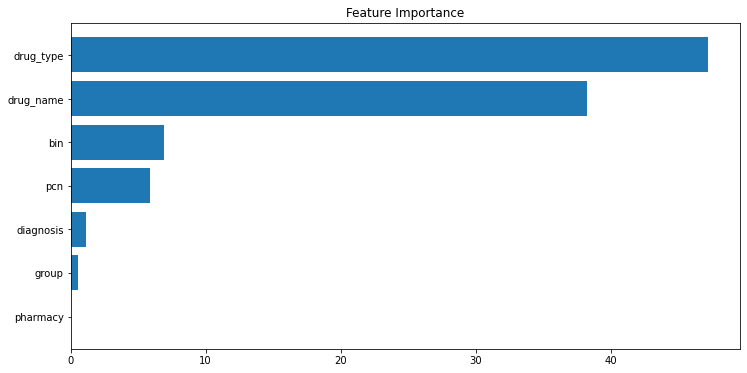

In [12]:
#feature importance
feature_importance = model_r.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [6]:
##Please skip this section
#Parameter Tuning: Rejection
# Rejection: features include pharmacy
X=df[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]
X_train, X_test, y_r_train, y_r_test = train_test_split(X.copy(),Y_r.copy(),
                                                       shuffle=True,
                                                       random_state=222,
                                                       stratify=Y_r,
                                                       test_size=.2)
cat_features = np.where(X.dtypes != float)[0]
train_data=Pool(data=X_train,label=y_r_train,cat_features=cat_features)
test_data=Pool(data=X_test,label=y_r_test,cat_features=cat_features)
model = CatBoostClassifier(learning_rate=0.3,
                           eval_metric='AUC')
model.fit(train_data,
          eval_set=test_data,
          verbose=False)
print(model.get_best_iteration())


28


In [14]:
#try different number of iterations
#model_r= CatBoostClassifier(iterations=1000,depth=6,learning_rate=0.4)
#max_ctr_complexity=1
#learning_rate=0.1,depth=8,task_type="GPU",devices='0:1'
#model_r.fit(train_data)

In [8]:
Y_r_pred = model_r.predict(X_test)
acc = sum(y_r_test == Y_r_pred)/len(Y_r_pred)
print(acc)

#accuracy = 92.19% with 50 iterations, learning_rate= 0.3, depth=10
#check how trained model perform on the training sample
print("predicted number of rejection in test sample is", sum(Y_r_pred))
print("observed number of rejection in test sample is",sum(y_r_test))


0.9218619082553902
predicted number of rejection in test sample is 42
observed number of rejection in test sample is 217372


In [ ]:
# the following code is testing whether rejection is based on features. 
# I first train the model without rejection data. Then predit the potential paytient pay of the rejeceted cases if they were not rejected
# Then compare the average of the predicted paytient pay of the rejected case and non-rejected cases
# There are significant differences in (possible) paytient pay between rejected cases and non-rejecred cases. 
# The rejected cases usually corresponde to a higher predicted paytient pay. But it's rejected, we only observe 0 for rejected cases. 

df_wor=df[df.rejected!=1]#data without rejection data
Y_wor=df_wor.patient_pay

X_wor=df_wor[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]

#subsample data
X_train, X_test, y_train, y_test = train_test_split(X_wor.copy(),Y_wor.copy(),
                                                       shuffle=True,
                                                       random_state=222,
                                                       test_size=.2)

cat_features = np.where(X_wor.dtypes != float)[0]
train_data=Pool(data=X_train,label=y_train,cat_features=cat_features)
#test_data=Pool(data=X_test,label=y_test,cat_features=cat_features)

model_r_wor= CatBoostRegressor(iterations=100)
#model= CatBoostRegressor(iterations=200,task_type="GPU",devices='0:1')
model_r_wor.fit(train_data,plot='true')
y_pred = model_r_wor.predict(X_test)
print(y_pred.mean())





In [ ]:
#rejection rate

df_wr=df[df.rejected==1]

X_wr=df_wr[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]

y_pred_wr = model.predict(X_wr)


In [ ]:
y_pred_wr.mean()

The rejected cases usually corresponde to a higher predicted paytient pay. 

In [61]:
# Patient Pay: features don't include pharmacy
X=df[['diagnosis','drug_type','drug_name','bin','pcn','group']]
#X=df[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]
#subsample data
X_train, X_test, y_train, y_test = train_test_split(X.copy(),Y.copy(),
                                                       shuffle=True,
                                                       random_state=222,
                                                       test_size=.2)

cat_features = np.where(X.dtypes != float)[0]
train_data=Pool(data=X_train,label=y_train,cat_features=cat_features)
#test_data=Pool(data=X_test,label=y_test,cat_features=cat_features)

In [62]:
#model= CatBoostRegressor(iterations=200)
model= CatBoostRegressor(iterations=200,task_type="GPU",devices='0:1')
model.fit(train_data,plot='true')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.357832
0:	learn: 34.2758998	total: 3.17s	remaining: 10m 31s
1:	learn: 31.7054692	total: 6.7s	remaining: 11m 3s
2:	learn: 29.8630458	total: 12.4s	remaining: 13m 37s
3:	learn: 29.0399183	total: 18.7s	remaining: 15m 17s
4:	learn: 28.5976472	total: 25.9s	remaining: 16m 51s
5:	learn: 28.1818015	total: 30.3s	remaining: 16m 19s
6:	learn: 28.0250863	total: 36.9s	remaining: 16m 57s
7:	learn: 27.8911007	total: 41.3s	remaining: 16m 30s
8:	learn: 27.8244050	total: 47s	remaining: 16m 36s
9:	learn: 27.7419332	total: 52.2s	remaining: 16m 30s
10:	learn: 27.6600055	total: 54.8s	remaining: 15m 42s
11:	learn: 27.5288050	total: 59.4s	remaining: 15m 31s
12:	learn: 27.4871779	total: 1m 4s	remaining: 15m 27s
13:	learn: 27.4078756	total: 1m 9s	remaining: 15m 24s
14:	learn: 27.3807556	total: 1m 14s	remaining: 15m 18s
15:	learn: 27.3389720	total: 1m 19s	remaining: 15m 13s
16:	learn: 27.3055246	total: 1m 24s	remaining: 15m 11s
17:	learn: 27.2002209	total: 1m 29s	remaining: 15m 1s
18:	learn

150:	learn: 25.8208848	total: 12m 1s	remaining: 3m 54s
151:	learn: 25.8198415	total: 12m 5s	remaining: 3m 49s
152:	learn: 25.8183179	total: 12m 10s	remaining: 3m 44s
153:	learn: 25.8133554	total: 12m 14s	remaining: 3m 39s
154:	learn: 25.8120631	total: 12m 19s	remaining: 3m 34s
155:	learn: 25.8103608	total: 12m 24s	remaining: 3m 29s
156:	learn: 25.8059360	total: 12m 28s	remaining: 3m 25s
157:	learn: 25.8039302	total: 12m 33s	remaining: 3m 20s
158:	learn: 25.8021551	total: 12m 37s	remaining: 3m 15s
159:	learn: 25.7932369	total: 12m 43s	remaining: 3m 10s
160:	learn: 25.7819655	total: 12m 49s	remaining: 3m 6s
161:	learn: 25.7753288	total: 12m 56s	remaining: 3m 2s
162:	learn: 25.7722985	total: 13m 1s	remaining: 2m 57s
163:	learn: 25.7689644	total: 13m 6s	remaining: 2m 52s
164:	learn: 25.7659575	total: 13m 11s	remaining: 2m 47s
165:	learn: 25.7652531	total: 13m 16s	remaining: 2m 43s
166:	learn: 25.7628289	total: 13m 23s	remaining: 2m 38s
167:	learn: 25.7579288	total: 13m 27s	remaining: 2m 33

In [16]:
#y_pred = model.predict(X_test)
#MSE=np.square(np.subtract(y_test,y_pred)).mean()
#print(MSE)

Text(0.5, 1.0, 'Feature Importance')

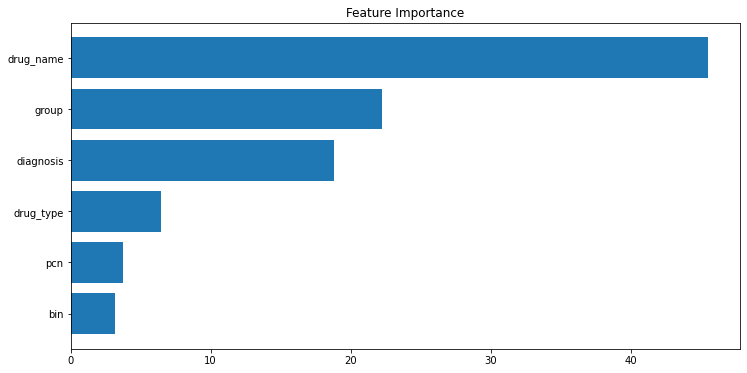

In [64]:
#feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [ ]:
#speed up with GPU
#model= CatBoostRegressor(iterations=200,depth=10,task_type="GPU",devices='0:1',max_ctr_complexity=1) 
#model.fit(train_data)

In [8]:
# Patient Pay: features include pharmacy
#X=df[['diagnosis','drug_type','drug_name','bin','pcn','group']]
X=df[['pharmacy','diagnosis','drug_type','drug_name','bin','pcn','group']]
#subsample data
X_train, X_test, y_train, y_test = train_test_split(X.copy(),Y.copy(),
                                                       shuffle=True,
                                                       random_state=222,
                                                       test_size=.2)

cat_features = np.where(X.dtypes != float)[0]
train_data=Pool(data=X_train,label=y_train,cat_features=cat_features)
#test_data=Pool(data=X_test,label=y_test,cat_features=cat_features)

In [9]:
#warning no enough gpu memory, increase iteration to 2000
model= CatBoostRegressor(iterations=2000,depth=6)
#model= CatBoostRegressor(iterations=200,depth=6,task_type="GPU",devices='0:1')
model.fit(train_data,plot='true')
y_pred = model.predict(X_test)
MSE=np.square(np.subtract(y_test,y_pred)).mean()
print(MSE)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.101573
0:	learn: 38.0979223	total: 5.2s	remaining: 2h 53m 21s
1:	learn: 36.8854104	total: 9.93s	remaining: 2h 45m 15s
2:	learn: 35.8769151	total: 13.9s	remaining: 2h 34m 13s
3:	learn: 35.0224452	total: 16.3s	remaining: 2h 15m 16s
4:	learn: 34.2512372	total: 19.5s	remaining: 2h 9m 47s
5:	learn: 33.4538794	total: 23.2s	remaining: 2h 8m 39s
6:	learn: 32.7469033	total: 26.3s	remaining: 2h 4m 51s
7:	learn: 32.1425972	total: 28.9s	remaining: 1h 59m 58s
8:	learn: 31.6444097	total: 31.4s	remaining: 1h 55m 50s
9:	learn: 31.2335267	total: 34.4s	remaining: 1h 54m 10s
10:	learn: 30.8893909	total: 37s	remaining: 1h 51m 21s
11:	learn: 30.5880284	total: 40.8s	remaining: 1h 52m 43s
12:	learn: 30.3383372	total: 43.4s	remaining: 1h 50m 26s
13:	learn: 30.1216024	total: 46s	remaining: 1h 48m 48s
14:	learn: 29.9454562	total: 48.5s	remaining: 1h 47m 4s
15:	learn: 29.7880253	total: 51.2s	remaining: 1h 45m 53s
16:	learn: 29.6556263	total: 53.6s	remaining: 1h 44m 17s
17:	learn: 29.541009

142:	learn: 27.9006411	total: 7m 44s	remaining: 1h 40m 34s
143:	learn: 27.8990581	total: 7m 47s	remaining: 1h 40m 23s
144:	learn: 27.8945611	total: 7m 49s	remaining: 1h 40m 12s
145:	learn: 27.8938372	total: 7m 52s	remaining: 1h 40m 2s
146:	learn: 27.8913387	total: 7m 55s	remaining: 1h 39m 51s
147:	learn: 27.8864064	total: 7m 57s	remaining: 1h 39m 38s
148:	learn: 27.8853852	total: 8m	remaining: 1h 39m 24s
149:	learn: 27.8830394	total: 8m 2s	remaining: 1h 39m 13s
150:	learn: 27.8803290	total: 8m 5s	remaining: 1h 39m 8s
151:	learn: 27.8778422	total: 8m 8s	remaining: 1h 38m 54s
152:	learn: 27.8726135	total: 8m 10s	remaining: 1h 38m 43s
153:	learn: 27.8682719	total: 8m 13s	remaining: 1h 38m 34s
154:	learn: 27.8661946	total: 8m 16s	remaining: 1h 38m 29s
155:	learn: 27.8661945	total: 8m 17s	remaining: 1h 38m 4s
156:	learn: 27.8645023	total: 8m 20s	remaining: 1h 37m 58s
157:	learn: 27.8638984	total: 8m 23s	remaining: 1h 37m 54s
158:	learn: 27.8621268	total: 8m 27s	remaining: 1h 37m 53s
159:	le

281:	learn: 27.6201471	total: 15m 2s	remaining: 1h 31m 35s
282:	learn: 27.6192906	total: 15m 5s	remaining: 1h 31m 32s
283:	learn: 27.6175307	total: 15m 9s	remaining: 1h 31m 34s
284:	learn: 27.6161383	total: 15m 11s	remaining: 1h 31m 27s
285:	learn: 27.6128702	total: 15m 15s	remaining: 1h 31m 28s
286:	learn: 27.6106641	total: 15m 18s	remaining: 1h 31m 24s
287:	learn: 27.6100654	total: 15m 22s	remaining: 1h 31m 24s
288:	learn: 27.6091174	total: 15m 25s	remaining: 1h 31m 18s
289:	learn: 27.6080356	total: 15m 29s	remaining: 1h 31m 18s
290:	learn: 27.6073938	total: 15m 32s	remaining: 1h 31m 18s
291:	learn: 27.6063400	total: 15m 36s	remaining: 1h 31m 17s
292:	learn: 27.6048567	total: 15m 40s	remaining: 1h 31m 17s
293:	learn: 27.6042440	total: 15m 43s	remaining: 1h 31m 14s
294:	learn: 27.5909495	total: 15m 49s	remaining: 1h 31m 25s
295:	learn: 27.5897775	total: 15m 53s	remaining: 1h 31m 31s
296:	learn: 27.5892502	total: 15m 56s	remaining: 1h 31m 25s
297:	learn: 27.5884074	total: 15m 59s	remai

419:	learn: 27.4568947	total: 22m 23s	remaining: 1h 24m 13s
420:	learn: 27.4564676	total: 22m 26s	remaining: 1h 24m 10s
421:	learn: 27.4560852	total: 22m 29s	remaining: 1h 24m 7s
422:	learn: 27.4559007	total: 22m 32s	remaining: 1h 24m 4s
423:	learn: 27.4555176	total: 22m 35s	remaining: 1h 23m 59s
424:	learn: 27.4552021	total: 22m 38s	remaining: 1h 23m 54s
425:	learn: 27.4546615	total: 22m 42s	remaining: 1h 23m 53s
426:	learn: 27.4541216	total: 22m 45s	remaining: 1h 23m 49s
427:	learn: 27.4526670	total: 22m 49s	remaining: 1h 23m 48s
428:	learn: 27.4521214	total: 22m 52s	remaining: 1h 23m 46s
429:	learn: 27.4519028	total: 22m 55s	remaining: 1h 23m 40s
430:	learn: 27.4506840	total: 22m 59s	remaining: 1h 23m 42s
431:	learn: 27.4501409	total: 23m 3s	remaining: 1h 23m 40s
432:	learn: 27.4495581	total: 23m 6s	remaining: 1h 23m 36s
433:	learn: 27.4491088	total: 23m 9s	remaining: 1h 23m 32s
434:	learn: 27.4486645	total: 23m 11s	remaining: 1h 23m 26s
435:	learn: 27.4477335	total: 23m 14s	remaini

557:	learn: 27.3534152	total: 29m 53s	remaining: 1h 17m 14s
558:	learn: 27.3533486	total: 29m 55s	remaining: 1h 17m 9s
559:	learn: 27.3530835	total: 29m 58s	remaining: 1h 17m 5s
560:	learn: 27.3529415	total: 30m 1s	remaining: 1h 17m
561:	learn: 27.3529208	total: 30m 3s	remaining: 1h 16m 54s
562:	learn: 27.3524560	total: 30m 5s	remaining: 1h 16m 49s
563:	learn: 27.3516451	total: 30m 8s	remaining: 1h 16m 44s
564:	learn: 27.3513774	total: 30m 10s	remaining: 1h 16m 39s
565:	learn: 27.3512316	total: 30m 14s	remaining: 1h 16m 35s
566:	learn: 27.3506188	total: 30m 17s	remaining: 1h 16m 32s
567:	learn: 27.3504759	total: 30m 20s	remaining: 1h 16m 28s
568:	learn: 27.3502759	total: 30m 22s	remaining: 1h 16m 23s
569:	learn: 27.3497531	total: 30m 24s	remaining: 1h 16m 18s
570:	learn: 27.3486511	total: 30m 27s	remaining: 1h 16m 14s
571:	learn: 27.3479633	total: 30m 30s	remaining: 1h 16m 9s
572:	learn: 27.3476212	total: 30m 32s	remaining: 1h 16m 4s
573:	learn: 27.3476201	total: 30m 35s	remaining: 1h 

695:	learn: 27.2492222	total: 37m 45s	remaining: 1h 10m 43s
696:	learn: 27.2489520	total: 37m 47s	remaining: 1h 10m 39s
697:	learn: 27.2442392	total: 37m 50s	remaining: 1h 10m 35s
698:	learn: 27.2442386	total: 37m 53s	remaining: 1h 10m 31s
699:	learn: 27.2439313	total: 37m 56s	remaining: 1h 10m 27s
700:	learn: 27.2434780	total: 37m 59s	remaining: 1h 10m 23s
701:	learn: 27.2430126	total: 38m 2s	remaining: 1h 10m 19s
702:	learn: 27.2429342	total: 38m 4s	remaining: 1h 10m 15s
703:	learn: 27.2427462	total: 38m 7s	remaining: 1h 10m 11s
704:	learn: 27.2424461	total: 38m 10s	remaining: 1h 10m 7s
705:	learn: 27.2416767	total: 38m 13s	remaining: 1h 10m 3s
706:	learn: 27.2413439	total: 38m 16s	remaining: 1h 9m 59s
707:	learn: 27.2402151	total: 38m 19s	remaining: 1h 9m 56s
708:	learn: 27.2395522	total: 38m 22s	remaining: 1h 9m 53s
709:	learn: 27.2386367	total: 38m 25s	remaining: 1h 9m 48s
710:	learn: 27.2376918	total: 38m 29s	remaining: 1h 9m 46s
711:	learn: 27.2370674	total: 38m 32s	remaining: 1

835:	learn: 27.1794452	total: 45m 23s	remaining: 1h 3m 11s
836:	learn: 27.1794139	total: 45m 26s	remaining: 1h 3m 8s
837:	learn: 27.1788320	total: 45m 29s	remaining: 1h 3m 4s
838:	learn: 27.1788272	total: 45m 32s	remaining: 1h 3m
839:	learn: 27.1786860	total: 45m 35s	remaining: 1h 2m 57s
840:	learn: 27.1785169	total: 45m 39s	remaining: 1h 2m 54s
841:	learn: 27.1779912	total: 45m 42s	remaining: 1h 2m 51s
842:	learn: 27.1779723	total: 45m 45s	remaining: 1h 2m 47s
843:	learn: 27.1754907	total: 45m 50s	remaining: 1h 2m 46s
844:	learn: 27.1740786	total: 45m 54s	remaining: 1h 2m 45s
845:	learn: 27.1733205	total: 45m 57s	remaining: 1h 2m 41s
846:	learn: 27.1725284	total: 46m 1s	remaining: 1h 2m 38s
847:	learn: 27.1724575	total: 46m 4s	remaining: 1h 2m 35s
848:	learn: 27.1724346	total: 46m 6s	remaining: 1h 2m 31s
849:	learn: 27.1723058	total: 46m 11s	remaining: 1h 2m 29s
850:	learn: 27.1722384	total: 46m 14s	remaining: 1h 2m 26s
851:	learn: 27.1719743	total: 46m 17s	remaining: 1h 2m 23s
852:	l

979:	learn: 27.1372469	total: 53m 10s	remaining: 55m 20s
980:	learn: 27.1372068	total: 53m 12s	remaining: 55m 16s
981:	learn: 27.1368349	total: 53m 16s	remaining: 55m 13s
982:	learn: 27.1366245	total: 53m 19s	remaining: 55m 9s
983:	learn: 27.1365656	total: 53m 21s	remaining: 55m 5s
984:	learn: 27.1362908	total: 53m 25s	remaining: 55m 2s
985:	learn: 27.1352140	total: 53m 28s	remaining: 54m 59s
986:	learn: 27.1351264	total: 53m 31s	remaining: 54m 56s
987:	learn: 27.1350612	total: 53m 34s	remaining: 54m 52s
988:	learn: 27.1348098	total: 53m 39s	remaining: 54m 51s
989:	learn: 27.1346253	total: 53m 42s	remaining: 54m 47s
990:	learn: 27.1345548	total: 53m 45s	remaining: 54m 44s
991:	learn: 27.1344905	total: 53m 48s	remaining: 54m 40s
992:	learn: 27.1344516	total: 53m 51s	remaining: 54m 37s
993:	learn: 27.1343148	total: 53m 55s	remaining: 54m 34s
994:	learn: 27.1337820	total: 53m 58s	remaining: 54m 30s
995:	learn: 27.1335189	total: 54m	remaining: 54m 26s
996:	learn: 27.1334021	total: 54m 2s	r

1122:	learn: 27.0672434	total: 1h 1m 11s	remaining: 47m 47s
1123:	learn: 27.0672148	total: 1h 1m 13s	remaining: 47m 43s
1124:	learn: 27.0671449	total: 1h 1m 16s	remaining: 47m 39s
1125:	learn: 27.0666829	total: 1h 1m 19s	remaining: 47m 35s
1126:	learn: 27.0659476	total: 1h 1m 23s	remaining: 47m 33s
1127:	learn: 27.0657223	total: 1h 1m 25s	remaining: 47m 29s
1128:	learn: 27.0656672	total: 1h 1m 29s	remaining: 47m 26s
1129:	learn: 27.0654048	total: 1h 1m 31s	remaining: 47m 22s
1130:	learn: 27.0650147	total: 1h 1m 35s	remaining: 47m 19s
1131:	learn: 27.0647704	total: 1h 1m 38s	remaining: 47m 16s
1132:	learn: 27.0646974	total: 1h 1m 42s	remaining: 47m 13s
1133:	learn: 27.0643294	total: 1h 1m 45s	remaining: 47m 9s
1134:	learn: 27.0641775	total: 1h 1m 48s	remaining: 47m 6s
1135:	learn: 27.0639974	total: 1h 1m 52s	remaining: 47m 3s
1136:	learn: 27.0637891	total: 1h 1m 56s	remaining: 47m
1137:	learn: 27.0636232	total: 1h 1m 59s	remaining: 46m 57s
1138:	learn: 27.0633564	total: 1h 2m 2s	remaini

1260:	learn: 27.0375861	total: 1h 8m 18s	remaining: 40m 1s
1261:	learn: 27.0375443	total: 1h 8m 21s	remaining: 39m 58s
1262:	learn: 27.0372907	total: 1h 8m 23s	remaining: 39m 54s
1263:	learn: 27.0371877	total: 1h 8m 26s	remaining: 39m 51s
1264:	learn: 27.0371858	total: 1h 8m 29s	remaining: 39m 47s
1265:	learn: 27.0369885	total: 1h 8m 32s	remaining: 39m 44s
1266:	learn: 27.0367501	total: 1h 8m 35s	remaining: 39m 40s
1267:	learn: 27.0362549	total: 1h 8m 39s	remaining: 39m 38s
1268:	learn: 27.0360551	total: 1h 8m 42s	remaining: 39m 35s
1269:	learn: 27.0359591	total: 1h 8m 46s	remaining: 39m 31s
1270:	learn: 27.0358997	total: 1h 8m 48s	remaining: 39m 27s
1271:	learn: 27.0358370	total: 1h 8m 51s	remaining: 39m 24s
1272:	learn: 27.0356980	total: 1h 8m 56s	remaining: 39m 22s
1273:	learn: 27.0355979	total: 1h 9m	remaining: 39m 19s
1274:	learn: 27.0354399	total: 1h 9m 3s	remaining: 39m 15s
1275:	learn: 27.0352898	total: 1h 9m 5s	remaining: 39m 12s
1276:	learn: 27.0352219	total: 1h 9m 9s	remaini

1396:	learn: 27.0147509	total: 1h 15m 43s	remaining: 32m 40s
1397:	learn: 27.0145709	total: 1h 15m 45s	remaining: 32m 37s
1398:	learn: 27.0145193	total: 1h 15m 48s	remaining: 32m 34s
1399:	learn: 27.0144925	total: 1h 15m 51s	remaining: 32m 30s
1400:	learn: 27.0144016	total: 1h 15m 54s	remaining: 32m 27s
1401:	learn: 27.0140730	total: 1h 15m 57s	remaining: 32m 23s
1402:	learn: 27.0140622	total: 1h 15m 59s	remaining: 32m 20s
1403:	learn: 27.0140024	total: 1h 16m 2s	remaining: 32m 16s
1404:	learn: 27.0138902	total: 1h 16m 5s	remaining: 32m 13s
1405:	learn: 27.0137667	total: 1h 16m 9s	remaining: 32m 10s
1406:	learn: 27.0134099	total: 1h 16m 12s	remaining: 32m 7s
1407:	learn: 27.0133377	total: 1h 16m 17s	remaining: 32m 4s
1408:	learn: 27.0132248	total: 1h 16m 21s	remaining: 32m 1s
1409:	learn: 27.0131608	total: 1h 16m 24s	remaining: 31m 58s
1410:	learn: 27.0129728	total: 1h 16m 27s	remaining: 31m 54s
1411:	learn: 27.0124876	total: 1h 16m 31s	remaining: 31m 51s
1412:	learn: 27.0123643	total:

1532:	learn: 26.9849589	total: 1h 23m 31s	remaining: 25m 26s
1533:	learn: 26.9849564	total: 1h 23m 33s	remaining: 25m 23s
1534:	learn: 26.9848284	total: 1h 23m 36s	remaining: 25m 19s
1535:	learn: 26.9846888	total: 1h 23m 38s	remaining: 25m 16s
1536:	learn: 26.9844376	total: 1h 23m 41s	remaining: 25m 12s
1537:	learn: 26.9839012	total: 1h 23m 45s	remaining: 25m 9s
1538:	learn: 26.9836212	total: 1h 23m 48s	remaining: 25m 6s
1539:	learn: 26.9832710	total: 1h 23m 51s	remaining: 25m 2s
1540:	learn: 26.9830637	total: 1h 23m 53s	remaining: 24m 59s
1541:	learn: 26.9828899	total: 1h 23m 56s	remaining: 24m 55s
1542:	learn: 26.9828708	total: 1h 23m 59s	remaining: 24m 52s
1543:	learn: 26.9826582	total: 1h 24m 1s	remaining: 24m 49s
1544:	learn: 26.9826289	total: 1h 24m 4s	remaining: 24m 45s
1545:	learn: 26.9823903	total: 1h 24m 7s	remaining: 24m 42s
1546:	learn: 26.9823722	total: 1h 24m 10s	remaining: 24m 38s
1547:	learn: 26.9822632	total: 1h 24m 12s	remaining: 24m 35s
1548:	learn: 26.9820978	total:

1668:	learn: 26.9629070	total: 1h 30m 33s	remaining: 17m 57s
1669:	learn: 26.9626443	total: 1h 30m 36s	remaining: 17m 54s
1670:	learn: 26.9626349	total: 1h 30m 39s	remaining: 17m 50s
1671:	learn: 26.9624140	total: 1h 30m 41s	remaining: 17m 47s
1672:	learn: 26.9624034	total: 1h 30m 44s	remaining: 17m 44s
1673:	learn: 26.9622828	total: 1h 30m 48s	remaining: 17m 41s
1674:	learn: 26.9619106	total: 1h 30m 51s	remaining: 17m 37s
1675:	learn: 26.9617656	total: 1h 30m 53s	remaining: 17m 34s
1676:	learn: 26.9614639	total: 1h 30m 56s	remaining: 17m 30s
1677:	learn: 26.9613191	total: 1h 30m 59s	remaining: 17m 27s
1678:	learn: 26.9609378	total: 1h 31m 2s	remaining: 17m 24s
1679:	learn: 26.9609286	total: 1h 31m 4s	remaining: 17m 20s
1680:	learn: 26.9609243	total: 1h 31m 7s	remaining: 17m 17s
1681:	learn: 26.9609171	total: 1h 31m 10s	remaining: 17m 14s
1682:	learn: 26.9605820	total: 1h 31m 12s	remaining: 17m 10s
1683:	learn: 26.9604579	total: 1h 31m 16s	remaining: 17m 7s
1684:	learn: 26.9602710	tota

1804:	learn: 26.9254244	total: 1h 38m 19s	remaining: 10m 37s
1805:	learn: 26.9253594	total: 1h 38m 22s	remaining: 10m 34s
1806:	learn: 26.9253376	total: 1h 38m 25s	remaining: 10m 30s
1807:	learn: 26.9250573	total: 1h 38m 29s	remaining: 10m 27s
1808:	learn: 26.9250283	total: 1h 38m 32s	remaining: 10m 24s
1809:	learn: 26.9248627	total: 1h 38m 34s	remaining: 10m 20s
1810:	learn: 26.9247877	total: 1h 38m 38s	remaining: 10m 17s
1811:	learn: 26.9247277	total: 1h 38m 40s	remaining: 10m 14s
1812:	learn: 26.9246933	total: 1h 38m 44s	remaining: 10m 11s
1813:	learn: 26.9245530	total: 1h 38m 47s	remaining: 10m 7s
1814:	learn: 26.9245111	total: 1h 38m 49s	remaining: 10m 4s
1815:	learn: 26.9244806	total: 1h 38m 52s	remaining: 10m 1s
1816:	learn: 26.9243390	total: 1h 38m 57s	remaining: 9m 58s
1817:	learn: 26.9241359	total: 1h 39m 2s	remaining: 9m 54s
1818:	learn: 26.9240901	total: 1h 39m 5s	remaining: 9m 51s
1819:	learn: 26.9240348	total: 1h 39m 7s	remaining: 9m 48s
1820:	learn: 26.9227861	total: 1h 

1942:	learn: 26.8992412	total: 1h 45m 28s	remaining: 3m 5s
1943:	learn: 26.8991973	total: 1h 45m 32s	remaining: 3m 2s
1944:	learn: 26.8991878	total: 1h 45m 35s	remaining: 2m 59s
1945:	learn: 26.8990481	total: 1h 45m 38s	remaining: 2m 55s
1946:	learn: 26.8989442	total: 1h 45m 42s	remaining: 2m 52s
1947:	learn: 26.8988029	total: 1h 45m 45s	remaining: 2m 49s
1948:	learn: 26.8987586	total: 1h 45m 49s	remaining: 2m 46s
1949:	learn: 26.8986751	total: 1h 45m 53s	remaining: 2m 42s
1950:	learn: 26.8986249	total: 1h 45m 56s	remaining: 2m 39s
1951:	learn: 26.8985881	total: 1h 45m 59s	remaining: 2m 36s
1952:	learn: 26.8985354	total: 1h 46m 4s	remaining: 2m 33s
1953:	learn: 26.8984962	total: 1h 46m 10s	remaining: 2m 29s
1954:	learn: 26.8984747	total: 1h 46m 13s	remaining: 2m 26s
1955:	learn: 26.8982868	total: 1h 46m 18s	remaining: 2m 23s
1956:	learn: 26.8981752	total: 1h 46m 22s	remaining: 2m 20s
1957:	learn: 26.8979632	total: 1h 46m 24s	remaining: 2m 16s
1958:	learn: 26.8979521	total: 1h 46m 27s	r

Text(0.5, 1.0, 'Feature Importance')

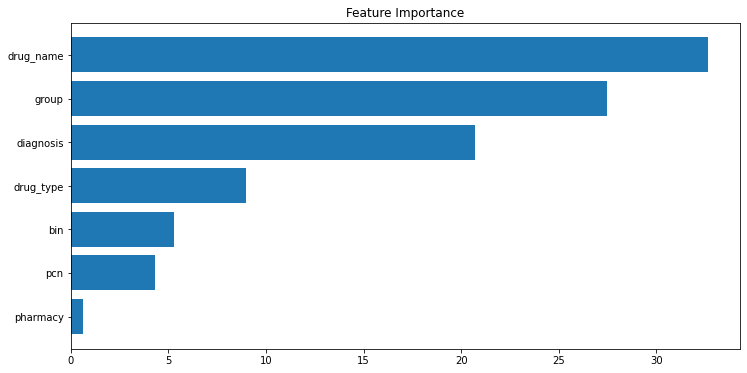

In [17]:

#feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')